In [1]:
print("hola")

hola


In [15]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import skfuzzy as fuzz

In [16]:
train_img_path = "Train_bmp"
train_mask_path = "Train_GT_bmp"

image_files = os.listdir(train_img_path)

In [17]:
def dice_score(pred, gt):
    intersection = np.sum(pred * gt)
    return (2.0 * intersection) / (np.sum(pred) + np.sum(gt) + 1e-8)

In [18]:
dice_kmeans_list = []
dice_fcm_list = []

for file in image_files[:20]:   # testing on first 20 images
    
    img = cv2.imread(os.path.join(train_img_path, file))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    gt = cv2.imread(os.path.join(train_mask_path, file), 0)
    gt = gt / 255

    pixels = img_rgb.reshape((-1, 3))
    pixels = np.float32(pixels)

    # K-Means (hard clustering)
    kmeans = KMeans(n_clusters=3, random_state=0)
    kmeans.fit(pixels)

    labels_k = kmeans.labels_.reshape(img.shape[:2])

    cluster_means = []
    for i in range(3):
        cluster_means.append(np.mean(img_rgb[labels_k == i]))

    nucleus_cluster = np.argmin(cluster_means)
    nucleus_k = (labels_k == nucleus_cluster).astype(int)

    dice_k = dice_score(nucleus_k, gt)
    dice_kmeans_list.append(dice_k)

    # FCM (soft clustering)
    pixels_T = pixels.T

    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
        pixels_T,
        c=3,
        m=2,
        error=0.005,
        maxiter=500,
        init=None
    )

    labels_f = np.argmax(u, axis=0).reshape(img.shape[:2])

    cluster_means_f = []
    for i in range(3):
        cluster_means_f.append(np.mean(img_rgb[labels_f == i]))

    nucleus_cluster_f = np.argmin(cluster_means_f)
    nucleus_f = (labels_f == nucleus_cluster_f).astype(int)

    dice_f = dice_score(nucleus_f, gt)
    dice_fcm_list.append(dice_f)

c:\Users\DELL\anaconda3\envs\mri_project\Lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\DELL\anaconda3\envs\mri_project\Lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\DELL\anaconda3\envs\mri_project\Lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\DELL\anaconda3\envs\mri_project\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as 

In [19]:
print("Average Dice (K-Means):", np.mean(dice_kmeans_list))
print("Average Dice (FCM):", np.mean(dice_fcm_list))

Average Dice (K-Means): 0.8689220350425731
Average Dice (FCM): 0.8718803193000115


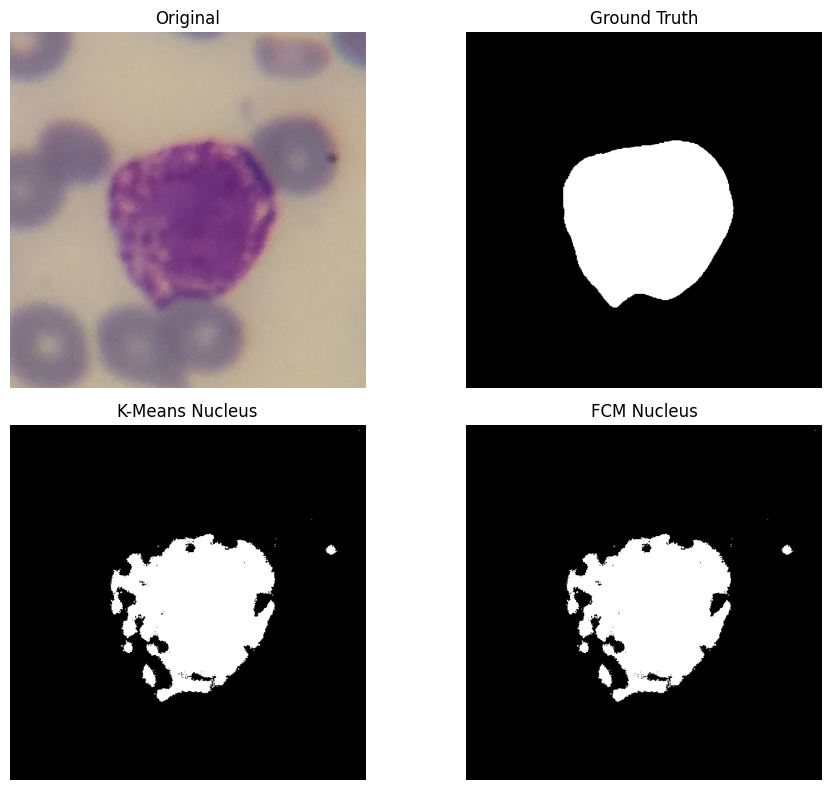

In [22]:
file = image_files[20]   # taking first image

img = cv2.imread(os.path.join(train_img_path, file))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

gt = cv2.imread(os.path.join(train_mask_path, file), 0)
gt = gt / 255

pixels = img_rgb.reshape((-1, 3))
pixels = np.float32(pixels)

# K-Means
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(pixels)
labels_k = kmeans.labels_.reshape(img.shape[:2])

cluster_means = []
for i in range(3):
    cluster_means.append(np.mean(img_rgb[labels_k == i]))

nucleus_cluster = np.argmin(cluster_means)
nucleus_k = (labels_k == nucleus_cluster).astype(int)

# FCM
pixels_T = pixels.T
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    pixels_T, c=3, m=2, error=0.005, maxiter=500, init=None
)

labels_f = np.argmax(u, axis=0).reshape(img.shape[:2])

cluster_means_f = []
for i in range(3):
    cluster_means_f.append(np.mean(img_rgb[labels_f == i]))

nucleus_cluster_f = np.argmin(cluster_means_f)
nucleus_f = (labels_f == nucleus_cluster_f).astype(int)

# Plot
plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
plt.imshow(img_rgb)
plt.title("Original")
plt.axis("off")

plt.subplot(2,2,2)
plt.imshow(gt, cmap="gray")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(2,2,3)
plt.imshow(nucleus_k, cmap="gray")
plt.title("K-Means Nucleus")
plt.axis("off")

plt.subplot(2,2,4)
plt.imshow(nucleus_f, cmap="gray")
plt.title("FCM Nucleus")
plt.axis("off")

plt.tight_layout()
plt.show()